# 1 Load Config and Network

In [1]:
%load_ext autoreload
%autoreload 2
# %cd /p/mmcardiac/Jerry/code/CINE-DENSE-Translation
%cd /home/jx8fh/Projects/LaMoD
# %cd /workspace/LaMoD
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from modules.data import check_dict

/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD


In [2]:
# USE GPU 0
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import json
config_fname = 'configs/ours-LaMoD.json'
config = json.load(open(config_fname))

In [4]:
from models.LaMoD import LaMoD
network = LaMoD(config['networks'], device).to(device)

Skip connect: False
Loading pretrained model from checkpoints/ours_registration.pth
Unrecognized keyword argument: beta_schedule_overwrite = True
Unrecognized keyword argument: load_pretrained = True
Unrecognized keyword argument: pretrained_model_path = checkpoints/ours_latent_diffusion.pth
beta_schedule_method='linear'
Loading pretrained model from checkpoints/ours_latent_diffusion.pth


/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Overwriting beta schedule with linear schedule with scale 30
ignorekwargs: {'type': 'DiffusionDecoder', 'drouput': 0.3, 'load_pretrained': True, 'pretrained_model_path': 'checkpoints/ours_motion_regression.pth'}
Decoder tanh_out:  False
Decoder: give_pre_end=False, tanh_out=False, out_scaling_factor=1
Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
Loading pretrained model from checkpoints/ours_motion_regression.pth


# 2 CINE Prediction

In [5]:
cine_DENSE_fname = '/scratch/jx8fh/2024-04-21-matched-cine-DENSE-from-Yu-all-with-resampled.npy'
cine_DENSE_data = np.load(cine_DENSE_fname, allow_pickle=True).tolist()

In [6]:
print(f"length of data: {len(cine_DENSE_data)}")
check_dict(cine_DENSE_data[0])

length of data: 105
AnalysisInfo                                                 dict_keys(['ResampleMethod', 'ResampleDistance', 'SpatialSmoothing', 'TemporalOrder', 'Xseed', 'Yseed', 'Zseed', 'FramesForAnalysis', 'Nmodel', 'PositionA', 'PositionB', 'Clockwise'])
AnalysisInstanceUID                                          1.3.6.1.4.1.9590.100.1.2.64946301013757307506911904523491151334
DENSEInfo                                                    dict_keys(['Name', 'UID', 'Type', 'MagIndex', 'PhaIndex', 'Number', 'PixelSpacing', 'Scale', 'EncFreq', 'SwapFlag', 'NegFlag'])
DENSE_Eul_displacement_field_Multipliers                     (3,)                
DENSE_Eul_displacement_field_X                               (48, 48, 51)        
DENSE_Eul_displacement_field_Y                               (48, 48, 51)        
DENSE_Lag_displacement_field_X                               (48, 48, 51)        
DENSE_Lag_displacement_field_Y                               (48, 48, 51)        
DENSE_frame

In [8]:
import numpy as np
import torch
from pathlib import Path
import tqdm
from skimage.transform import resize
from skimage.morphology import dilation, disk

n_repeats = 100
cine_save_pred_dir = Path('/scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/cine')
cine_save_pred_dir.mkdir(exist_ok=True, parents=True)

for check_data_idx, check_datum in tqdm.tqdm(enumerate(cine_DENSE_data)):
    if check_data_idx < 20:
        continue
    inference_mask_raw = torch.from_numpy(
        resize(check_datum['cine_cropped_myocardium_masks_rescaled_1mm2'][...,0]>0.5, [48,48], anti_aliasing=False)
    )
    inference_mask = torch.from_numpy(dilation(inference_mask_raw, disk(2)))
    
    inference_input_video = torch.from_numpy(check_datum['cine_cropped_myocardium_masks_rescaled_1mm2']).to(device).moveaxis(-1,0)[None, None]
    inference_input_video_ori_frame = inference_input_video.shape[2]

    patient_repeats = []
    for repeat_idx in range(n_repeats):
        inference_output_dict = network.inference(
            inference_input_video, 
            ori_n_frames=[inference_input_video_ori_frame],
            skip_diffusion=False)[0]
        inference_disp = inference_output_dict['LaMoD_disp'].detach().cpu() / 2.73

        inference_disp_masked = inference_disp.clone()
        for cine_frame_idx in range(inference_disp.shape[2]):
            inference_disp_masked[0, 0, cine_frame_idx][~inference_mask_raw] = np.nan
            inference_disp_masked[0, 1, cine_frame_idx][~inference_mask_raw] = np.nan

        save_dict = {
            'disp_GT': np.concatenate((check_datum['DENSE_Lag_displacement_field_X'][None], check_datum['DENSE_Lag_displacement_field_Y'][None]), axis=0),
            'disp_pred': np.moveaxis(inference_disp_masked.numpy()[0], 1, -1),
            'disp_pred_unmasked': np.moveaxis(inference_disp.numpy()[0], 1, -1),
            'mask_raw': inference_mask_raw.numpy(),
            'mask': inference_mask.numpy(),
            'DENSE_frame_time_stamps': check_datum['DENSE_frame_time_stamps'],
            'cine_frame_time_stamps': check_datum['cine_frame_time_stamps'][:inference_disp.shape[2]],
            'DENSE_myo_mask_bbox': check_datum['DENSE_myo_mask_bbox'],
            'AnalysisInfo': check_datum['AnalysisInfo'],
            'cine_rv_insertion_points_rescaled_DENSE48': check_datum['cine_rv_insertion_points_rescaled_DENSE48']
        }
        
        patient_repeats.append(save_dict)
    
    patient_id = check_datum['patient_id']
    datum_slide_location = check_datum['DENSE_slice_location']
    save_path = cine_save_pred_dir / f'LaMoD-cine-{check_data_idx:03d}-{patient_id}-{int(np.floor(datum_slide_location))}.npy'
    np.save(save_path, patient_repeats)

105it [42:57, 24.55s/it]


In [9]:
from modules.data.processing.strain_analysis.pixelstrain import pixelstrain
from modules.data.processing.strain_analysis.resample_strain_matrix import resample_strain_matrix_2d
from modules.data.processing.strain_analysis.six_segments_core import six_segments_core, get_various_segmental_strain_data
import numpy as np
from pathlib import Path
import tqdm
from copy import deepcopy

cine_save_pred_dir = Path('/scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/cine')
cine_save_strain_dir = Path('/scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/cine_strain')
cine_save_strain_dir.mkdir(exist_ok=True, parents=True)

for file_path in tqdm.tqdm(list(cine_save_pred_dir.glob('*.npy'))):
    patient_repeats = np.load(file_path, allow_pickle=True)
    
    strain_results = []
    for repeat_data in patient_repeats:
        H, W = repeat_data['disp_pred'].shape[1:3]
        X, Y = np.meshgrid(np.arange(W), np.arange(H))
        dXt = repeat_data['disp_pred_unmasked'][0]
        dYt = repeat_data['disp_pred_unmasked'][1]
        mask = repeat_data['mask']
        Nfr = repeat_data['disp_pred'].shape[-1]
        
        strain = pixelstrain(X=X, Y=Y, dXt=dXt, dYt=dYt, mask=mask, times=np.arange(Nfr))
        strainCC = strain['CC']

        mask_GT = (np.abs(repeat_data['disp_GT'][0, ..., 0]) + np.abs(repeat_data['disp_GT'][1, ..., 0])) > 0
        Nfr_DENSE = repeat_data['disp_GT'].shape[-1]
        cine_strain_GT = pixelstrain(
            X=X, Y=Y, 
            dXt=repeat_data['disp_GT'][0], 
            dYt=repeat_data['disp_GT'][1], 
            mask=mask_GT, times=np.arange(Nfr_DENSE))
        
        cine_recompute_strain = get_various_segmental_strain_data(
            strain_images=strain['CC'], 
            strain_mask=~np.isnan(strain['CC'][...,0]), 
            origin=np.array([24,24]), 
            insertion=repeat_data['cine_rv_insertion_points_rescaled_DENSE48'],
            enable_offset=True,
            offset_degrees=[90, 120, 120],
            generate_layerid_map=False)

        cine_DENSE_strain_imgs = cine_strain_GT['CC']
        cine_DENSE_strain_mask = np.abs(repeat_data['disp_GT'][0, ..., 0]) > 1e-5
        cine_DENSE_origin = repeat_data['AnalysisInfo']['PositionA'] - np.array([repeat_data['DENSE_myo_mask_bbox'][2], repeat_data['DENSE_myo_mask_bbox'][0]])
        cine_DENSE_insertion = repeat_data['AnalysisInfo']['PositionB'] - np.array([repeat_data['DENSE_myo_mask_bbox'][2], repeat_data['DENSE_myo_mask_bbox'][0]])
        cine_DENSE_recompute_strain = get_various_segmental_strain_data(
            cine_DENSE_strain_imgs, 
            cine_DENSE_strain_mask, 
            cine_DENSE_origin, 
            cine_DENSE_insertion,
            layerid_map = None,
            generate_layerid_map=True)
        
        cine_DENSE_time_stamps = repeat_data['DENSE_frame_time_stamps']
        cine_time_stamps = repeat_data['cine_frame_time_stamps']
        
        for strainmat_name in ['CCs4', 'CCs6', 'CCs18']:
            cine_DENSE_recompute_strain[strainmat_name+'Resampled'] = resample_strain_matrix_2d(cine_DENSE_recompute_strain[strainmat_name], cine_DENSE_time_stamps, cine_time_stamps)
            cine_recompute_strain[strainmat_name+'Resampled'] = resample_strain_matrix_2d(cine_recompute_strain[strainmat_name], cine_time_stamps, cine_DENSE_time_stamps)

        strain_result = {
            'strain_GT': cine_DENSE_strain_imgs,
            'strain_pred': strain['CC']
        }
        for strainmat_name in cine_recompute_strain.keys():
            strain_result[strainmat_name+'_pred'] = cine_recompute_strain[strainmat_name]
        for strainmat_name in cine_DENSE_recompute_strain.keys():
            strain_result[strainmat_name+'_GT'] = cine_DENSE_recompute_strain[strainmat_name]
        
        strain_results.append(strain_result)
    
    strain_save_path = cine_save_strain_dir / file_path.name
    np.save(strain_save_path, strain_results)
    # break

  1%|          | 1/105 [02:11<3:47:04, 131.01s/it]/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
  6%|▌         | 6/105 [11:40<3:27:22, 125.68s/it]

In [ ]:
from modules.data.processing.strain_analysis.pixelstrain import pixelstrain
from modules.data.processing.strain_analysis.resample_strain_matrix import resample_strain_matrix_2d
from modules.data.processing.strain_analysis.six_segments_core import six_segments_core, get_various_segmental_strain_data
import numpy as np
from pathlib import Path
import tqdm
from copy import deepcopy
import multiprocessing

def process_repeat(repeat_data):
    H, W = repeat_data['disp_pred'].shape[1:3]
    X, Y = np.meshgrid(np.arange(W), np.arange(H))
    dXt = repeat_data['disp_pred_unmasked'][0]
    dYt = repeat_data['disp_pred_unmasked'][1]
    mask = repeat_data['mask']
    Nfr = repeat_data['disp_pred'].shape[-1]
    
    strain = pixelstrain(X=X, Y=Y, dXt=dXt, dYt=dYt, mask=mask, times=np.arange(Nfr))
    strainCC = strain['CC']

    mask_GT = (np.abs(repeat_data['disp_GT'][0, ..., 0]) + np.abs(repeat_data['disp_GT'][1, ..., 0])) > 0
    Nfr_DENSE = repeat_data['disp_GT'].shape[-1]
    cine_strain_GT = pixelstrain(
        X=X, Y=Y, 
        dXt=repeat_data['disp_GT'][0], 
        dYt=repeat_data['disp_GT'][1], 
        mask=mask_GT, times=np.arange(Nfr_DENSE))
    
    cine_recompute_strain = get_various_segmental_strain_data(
        strain_images=strain['CC'], 
        strain_mask=~np.isnan(strain['CC'][...,0]), 
        origin=np.array([24,24]), 
        insertion=repeat_data['cine_rv_insertion_points_rescaled_DENSE48'],
        enable_offset=True,
        offset_degrees=[90, 120, 120],
        generate_layerid_map=False)

    cine_DENSE_strain_imgs = cine_strain_GT['CC']
    cine_DENSE_strain_mask = np.abs(repeat_data['disp_GT'][0, ..., 0]) > 1e-5
    cine_DENSE_origin = repeat_data['AnalysisInfo']['PositionA'] - np.array([repeat_data['DENSE_myo_mask_bbox'][2], repeat_data['DENSE_myo_mask_bbox'][0]])
    cine_DENSE_insertion = repeat_data['AnalysisInfo']['PositionB'] - np.array([repeat_data['DENSE_myo_mask_bbox'][2], repeat_data['DENSE_myo_mask_bbox'][0]])
    cine_DENSE_recompute_strain = get_various_segmental_strain_data(
        cine_DENSE_strain_imgs, 
        cine_DENSE_strain_mask, 
        cine_DENSE_origin, 
        cine_DENSE_insertion,
        layerid_map = None,
        generate_layerid_map=True)
    
    cine_DENSE_time_stamps = repeat_data['DENSE_frame_time_stamps']
    cine_time_stamps = repeat_data['cine_frame_time_stamps']
    
    for strainmat_name in ['CCs4', 'CCs6', 'CCs18']:
        cine_DENSE_recompute_strain[strainmat_name+'Resampled'] = resample_strain_matrix_2d(cine_DENSE_recompute_strain[strainmat_name], cine_DENSE_time_stamps, cine_time_stamps)
        cine_recompute_strain[strainmat_name+'Resampled'] = resample_strain_matrix_2d(cine_recompute_strain[strainmat_name], cine_time_stamps, cine_DENSE_time_stamps)

    strain_result = {
        'strain_GT': cine_DENSE_strain_imgs,
        'strain_pred': strain['CC']
    }
    for strainmat_name in cine_recompute_strain.keys():
        strain_result[strainmat_name+'_pred'] = cine_recompute_strain[strainmat_name]
    for strainmat_name in cine_DENSE_recompute_strain.keys():
        strain_result[strainmat_name+'_GT'] = cine_DENSE_recompute_strain[strainmat_name]
    
    return strain_result

cine_save_pred_dir = Path('/scratch/jx8fh/2025-01-16-LaMoD-variability-split/cine')
cine_save_strain_dir = Path('/scratch/jx8fh/2025-01-16-LaMoD-variability-split/cine_strain')
cine_save_strain_dir.mkdir(exist_ok=True, parents=True)

for file_path in tqdm.tqdm(list(cine_save_pred_dir.glob('*.npy'))):
    patient_repeats = np.load(file_path, allow_pickle=True)
    
    # Use multiprocessing to parallelize the strain computation
    with multiprocessing.Pool() as pool:
        strain_results = pool.map(process_repeat, patient_repeats)
    
    strain_save_path = cine_save_strain_dir / file_path.name
    np.save(strain_save_path, strain_results)

  0%|          | 0/105 [00:00<?, ?it/s]/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
  0%|          | 0/105 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [31]:
check_dict(cine_recompute_strain)

origin                                                       (2,)                
insertion                                                    (2,)                
CCs4                                                         (4, 24)             
CCs6                                                         (6, 24)             
CCs18                                                        (18, 24)            
Seg4                                                         dict_keys(['insertion_shifted', 'BasisNames', 'BasisID', 'SegmentID'])
Seg6                                                         dict_keys(['insertion_shifted', 'BasisNames', 'BasisID', 'SegmentID'])
Seg18                                                        dict_keys(['insertion_shifted', 'BasisNames', 'BasisID', 'SegmentID'])
CCs4Resampled                                                (4, 57)             
CCs6Resampled                                                (6, 57)             
CCs18Resampled                

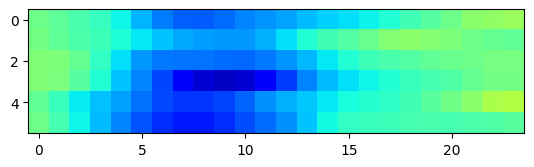

In [33]:
plt.imshow(cine_recompute_strain['CCs6'], cmap='jet', vmin=-0.2, vmax=0.2)

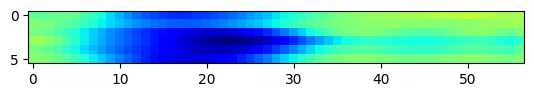

In [34]:
plt.imshow(cine_DENSE_recompute_strain['CCs6'], cmap='jet', vmin=-0.2, vmax=0.2)

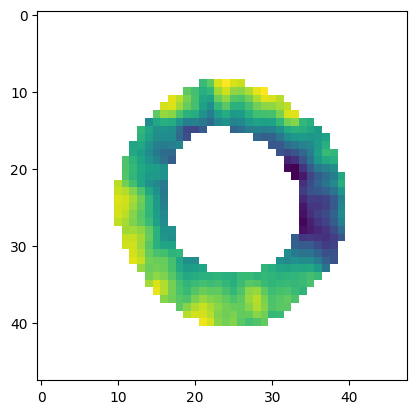

In [29]:
plt.imshow(strainCC[:,:,10])

# DENSE

In [5]:
# test_DENSE_data = np.load('/p/mmcardiac/Jerry/code/CINE-DENSE-Translation/data/DENSE/2024-04-16-test-data.npy', allow_pickle=True).tolist()
test_DENSE_data = np.load('/scratch/jx8fh/2024-04-16-test-data.npy', allow_pickle=True).tolist()
# test_DENSE_data = np.load('/scratch/jx8fh/2024-06-22-MICCAI-ShapeMI-Workshop-data/lamod_test.npy', allow_pickle=True).tolist()
print(f"len(test_DENSE_data) = {len(test_DENSE_data)}")
check_dict(test_DENSE_data[0])

len(test_DENSE_data) = 102
patient_id                                                   033                 
DENSE_slice_mat_filename                                     /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/033_S01_base_auto.1_ROI.1.mat
DENSE_slice_location                                         76.947609505431     
DENSE_frame_time_stamps                                      (51,)               
DENSE_Lag_displacement_field_X                               (48, 48, 51)        
DENSE_Lag_displacement_field_Y                               (48, 48, 51)        
DENSE_myo_masks                                              (48, 48, 51)        
DENSE_myo_mask_bbox                                          (34, 82, 40, 88)    
DENSE_myo_masks_rescaled                                     (128, 128, 51)      
DENSE_n_frames_all                                           51                  
DENSE_frame_indices_with_myo_contour                         (51,)            

In [6]:
import numpy as np
import torch
from pathlib import Path
import tqdm

n_repeats = 100
skip_diffusion = True
DENSE_save_pred_dir = Path('/scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE')
DENSE_save_pred_dir.mkdir(exist_ok=True, parents=True)

for check_data_idx, check_datum in tqdm.tqdm(enumerate(test_DENSE_data)):
    if check_data_idx < 38:
        continue
    mask_GT = (np.abs(check_datum['DENSE_Lag_displacement_field_X'][...,0]) + np.abs(check_datum['DENSE_Lag_displacement_field_Y'][...,0])) > 0
    inference_mask = torch.from_numpy(mask_GT)
    
    inference_input_video = torch.from_numpy(check_datum['DENSE_myo_masks_rescaled']).to(device).moveaxis(-1,0)[None, None]
    inference_input_video_ori_frame = inference_input_video.shape[2]

    patient_repeats = []
    for repeat_idx in range(n_repeats):
        inference_output_dict = network.inference(
            inference_input_video, 
            ori_n_frames=[inference_input_video_ori_frame],
            skip_diffusion=False)[0]
        inference_disp = inference_output_dict['LaMoD_disp'].detach().cpu() / 2.73

        inference_disp_masked = inference_disp * inference_mask[None]

        save_dict = {
            'disp_GT': np.concatenate((check_datum['DENSE_Lag_displacement_field_X'][None], check_datum['DENSE_Lag_displacement_field_Y'][None]), axis=0),
            'disp_pred': np.moveaxis(inference_disp_masked.numpy()[0], 1, -1),
            'disp_pred_unmasked': np.moveaxis(inference_disp.numpy()[0], 1, -1),
            'disp_mask': inference_mask.numpy(),
            'DENSE_frame_time_stamps': check_datum['DENSE_frame_time_stamps'],
            'DENSE_myo_mask_bbox': check_datum['DENSE_myo_mask_bbox'],
            'AnalysisInfo': check_datum['AnalysisInfo']
        }
        
        patient_repeats.append(save_dict)
    
    patient_id = check_datum['patient_id']
    datum_slide_location = check_datum['DENSE_slice_location']
    # save_path = DENSE_save_pred_dir / f'LaMoD-DENSE-SkipDiffusion-{check_data_idx:03d}-{patient_id}-{int(np.floor(datum_slide_location))}.npy'
    save_path = DENSE_save_pred_dir / f'LaMoD-DENSE-{check_data_idx:03d}-{patient_id}-{int(np.floor(datum_slide_location))}.npy'
    np.save(save_path, patient_repeats)
    print(f'Save to {save_path}')

0it [00:00, ?it/s]

39it [00:35,  1.10it/s]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-038-CT40--80.npy


40it [01:04,  1.89s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-039-CT40--100.npy


41it [01:32,  3.16s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-040-CT40--120.npy


42it [03:04,  8.86s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-041-Emory_04--94.npy


43it [04:35, 15.76s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-042-Emory_04--107.npy


44it [06:06, 23.86s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-043-Emory_04--126.npy


45it [07:38, 32.89s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-044-Emory_06-34.npy


46it [09:09, 42.12s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-045-Emory_06-43.npy


47it [10:40, 51.19s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-046-Emory_06--61.npy


48it [12:12, 59.71s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-047-Emory_07-24.npy


49it [13:43, 66.93s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-048-Emory_07--38.npy


50it [15:14, 72.97s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-049-Emory_07--48.npy


51it [16:10, 68.66s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-050-Lyon69_ene_al--53.npy


52it [17:06, 65.06s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-051-Lyon69_ene_al--67.npy


53it [18:01, 62.39s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-052-Lyon69_ene_al--81.npy


54it [18:59, 61.16s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-053-Lyon_Cha_Jea-47.npy


55it [19:57, 60.21s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-054-Lyon_Cha_Jea-89.npy


56it [20:53, 58.93s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-055-Lyon_Ene_Alex--38.npy


57it [21:49, 58.16s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-056-Lyon_Ene_Alex--52.npy


58it [22:45, 57.50s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-057-Lyon_Ene_Alex--66.npy


59it [24:34, 72.68s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-058-Lyon_d04_scanA--46.npy


60it [26:22, 83.25s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-059-Lyon_d04_scanA--18.npy


61it [28:10, 90.74s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-060-Lyon_d04_scanA--32.npy


62it [28:52, 76.11s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-061-OB015-37.npy


63it [29:35, 66.17s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-062-OB015-77.npy


64it [30:18, 59.25s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-063-OB016-13.npy


65it [31:01, 54.26s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-064-OB016-39.npy


66it [31:30, 46.62s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-065-OB017-25.npy


67it [31:58, 41.28s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-066-OB017-39.npy


68it [32:41, 41.66s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-067-OB018-94.npy


69it [33:23, 41.82s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-068-OB018-60.npy


70it [34:06, 42.05s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-069-OB018-77.npy


71it [35:02, 46.39s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-070-OB019--56.npy


72it [35:59, 49.54s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-071-OB019--40.npy


73it [37:11, 56.28s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-072-P117-50.npy


74it [38:23, 60.88s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-073-P117-60.npy


75it [39:35, 64.33s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-074-P117-69.npy


76it [40:47, 66.46s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-075-P117-79.npy


77it [42:01, 68.97s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-076-StFrancis_DENSE10A--39.npy


78it [43:17, 70.84s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-077-StFrancis_DENSE10A--23.npy


79it [44:16, 67.28s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-078-StFrancis_DENSE11A-13.npy


80it [45:15, 64.94s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-079-StFrancis_DENSE11A-29.npy


81it [46:15, 63.31s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-080-StFrancis_DENSE11A-45.npy


82it [48:01, 76.38s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-081-UVA_04--106.npy


83it [49:49, 85.72s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-082-UVA_04--125.npy


84it [51:37, 92.28s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-083-UVA_04--144.npy


85it [52:20, 77.72s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-084-UVA_05192021-57.npy


86it [53:04, 67.49s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-085-UVA_05192021-76.npy


87it [53:47, 60.12s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-086-UVA_05192021-96.npy


88it [55:00, 63.97s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-087-UVA_05--77.npy


89it [56:13, 66.62s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-088-UVA_05--93.npy


90it [57:25, 68.50s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-089-UVA_05--109.npy


91it [58:57, 75.39s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-090-UVA_07-12.npy


92it [1:00:28, 80.13s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-091-UVA_07-28.npy


93it [1:01:59, 83.46s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-092-UVA_07-44.npy


94it [1:03:16, 81.32s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-093-UVA_08_A_U1-18.npy


95it [1:04:32, 79.81s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-094-UVA_08_A_U1-34.npy


96it [1:06:03, 83.24s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-095-UVA_08_A_U1-50.npy


97it [1:07:35, 85.76s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-096-UVA_09_A_U1--21.npy


98it [1:09:21, 92.00s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-097-UVA_09_A_U1--37.npy


99it [1:10:54, 92.04s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-098-UVA_09_A_U1--53.npy


100it [1:12:13, 88.21s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-099-UVA_11_A_U1--55.npy


101it [1:13:28, 84.35s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-100-UVA_11_A_U1--79.npy


102it [1:14:43, 43.96s/it]

Save to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE/LaMoD-DENSE-101-UVA_11_A_U1--103.npy


In [6]:
from modules.data.processing.strain_analysis.pixelstrain import pixelstrain
from modules.data.processing.strain_analysis.six_segments_core import get_various_segmental_strain_data
import numpy as np
from pathlib import Path
import tqdm
import multiprocessing as mp

def process_repeat_data(repeat_data):
    H, W = repeat_data['disp_pred'].shape[1:3]
    X, Y = np.meshgrid(np.arange(W), np.arange(H))
    dXt = repeat_data['disp_pred_unmasked'][0]
    dYt = repeat_data['disp_pred_unmasked'][1]
    mask = repeat_data['disp_mask']
    Nfr = repeat_data['disp_pred'].shape[-1]
    
    strain = pixelstrain(X=X, Y=Y, dXt=dXt, dYt=dYt, mask=mask, times=np.arange(Nfr))
    
    Nfr_GT = repeat_data['disp_GT'].shape[-1]
    strain_GT = pixelstrain(
        X=X, Y=Y, 
        dXt=repeat_data['disp_GT'][0], 
        dYt=repeat_data['disp_GT'][1], 
        mask=mask, times=np.arange(Nfr_GT))
    
    DENSE_origin = repeat_data['AnalysisInfo']['PositionA'] - np.array([repeat_data['DENSE_myo_mask_bbox'][2], repeat_data['DENSE_myo_mask_bbox'][0]])
    DENSE_insertion = repeat_data['AnalysisInfo']['PositionB'] - np.array([repeat_data['DENSE_myo_mask_bbox'][2], repeat_data['DENSE_myo_mask_bbox'][0]])
    
    recompute_strain = get_various_segmental_strain_data(
        strain_images=strain['CC'], 
        strain_mask=~np.isnan(strain['CC'][...,0]), 
        origin=DENSE_origin, 
        insertion=DENSE_insertion,
        enable_offset=False,
        offset_degrees=[90, 120, 120],
        generate_layerid_map=False)

    DENSE_strain_imgs = strain_GT['CC']
    DENSE_strain_mask = np.abs(repeat_data['disp_GT'][0, ..., 0]) > 1e-5        
    DENSE_recompute_strain = get_various_segmental_strain_data(
        DENSE_strain_imgs, 
        DENSE_strain_mask, 
        DENSE_origin, 
        DENSE_insertion,
        layerid_map = None,
        generate_layerid_map=True)

    strain_result = {
        'strain_GT': DENSE_strain_imgs,
        'strain_pred': strain['CC']
    }
    for strainmat_name in recompute_strain.keys():
        strain_result[strainmat_name+'_pred'] = recompute_strain[strainmat_name]
    for strainmat_name in DENSE_recompute_strain.keys():
        strain_result[strainmat_name+'_GT'] = DENSE_recompute_strain[strainmat_name]
    
    return strain_result

DENSE_save_pred_dir = Path('/scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE')
DENSE_save_strain_dir = Path('/scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain')
DENSE_save_strain_dir.mkdir(exist_ok=True, parents=True)

for file_path in tqdm.tqdm(list(DENSE_save_pred_dir.glob('*.npy'))):
    patient_repeats = np.load(file_path, allow_pickle=True)
    
    # Use all available CPU cores
    num_processes = mp.cpu_count()
    
    with mp.Pool(processes=num_processes) as pool:
        strain_results = pool.map(process_repeat_data, patient_repeats)
    
    strain_save_path = DENSE_save_strain_dir / file_path.name
    np.save(strain_save_path, strain_results)
    print(f'Saved strain results to {strain_save_path}')

  1%|          | 1/102 [00:12<21:50, 12.98s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-087-UVA_05--77.npy


  2%|▏         | 2/102 [00:20<16:42, 10.03s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-033-CT03-127.npy


  3%|▎         | 3/102 [00:30<16:23,  9.93s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-072-P117-50.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: Run

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-064-OB016-39.npy


  5%|▍         | 5/102 [00:52<17:14, 10.66s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-050-Lyon69_ene_al--53.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = stra

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-034-CT03-137.npy


  7%|▋         | 7/102 [01:16<18:46, 11.86s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-053-Lyon_Cha_Jea-47.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/pro

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-093-UVA_08_A_U1-18.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/ho

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-058-Lyon_d04_scanA--46.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-package

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-041-Emory_04--94.npy


 11%|█         | 11/102 [02:17<22:45, 15.01s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-052-Lyon69_ene_al--81.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide 

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-006-122--91.npy


 13%|█▎        | 13/102 [02:39<19:23, 13.07s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-084-UVA_05192021-57.npy


 14%|█▎        | 14/102 [02:50<18:04, 12.32s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-014-125-103.npy


 15%|█▍        | 15/102 [03:03<17:59, 12.41s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-085-UVA_05192021-76.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = stra

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-037-CT22-110.npy


 17%|█▋        | 17/102 [03:28<18:22, 12.97s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-046-Emory_06--61.npy


 18%|█▊        | 18/102 [03:44<19:39, 14.04s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-060-Lyon_d04_scanA--32.npy


 19%|█▊        | 19/102 [04:00<20:02, 14.49s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-082-UVA_04--125.npy


 20%|█▉        | 20/102 [04:22<22:55, 16.77s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-045-Emory_06-43.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = str

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-078-StFrancis_DENSE11A-13.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = stra

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-038-CT40--80.npy


 23%|██▎       | 23/102 [04:52<16:41, 12.68s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-077-StFrancis_DENSE10A--23.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-package

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-089-UVA_05--109.npy


 25%|██▍       | 25/102 [05:21<17:32, 13.67s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-001-033-86.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-package

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-004-122--62.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: Run

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-027-CRT104-66.npy


 27%|██▋       | 28/102 [05:50<13:12, 10.70s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-029-CT01-62.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: Run

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-065-OB017-25.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/h

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-059-Lyon_d04_scanA--18.npy


 30%|███       | 31/102 [06:22<13:27, 11.38s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-051-Lyon69_ene_al--67.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/pro

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-005-122--71.npy


 32%|███▏      | 33/102 [06:42<12:13, 10.63s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-025-17--78.npy


 33%|███▎      | 34/102 [06:51<11:16,  9.94s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-040-CT40--120.npy


 34%|███▍      | 35/102 [07:04<12:07, 10.86s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-015-136--73.npy


 35%|███▌      | 36/102 [07:29<16:39, 15.15s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-044-Emory_06-34.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide 

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-091-UVA_07-28.npy


 37%|███▋      | 38/102 [08:00<16:41, 15.64s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-081-UVA_04--106.npy


 38%|███▊      | 39/102 [08:18<17:00, 16.19s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-003-033-115.npy


 39%|███▉      | 40/102 [08:33<16:20, 15.81s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-011-125-55.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = stra

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-035-CT22-70.npy


 41%|████      | 42/102 [08:59<14:49, 14.83s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-000-033-76.npy


 42%|████▏     | 43/102 [09:12<13:54, 14.15s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-076-StFrancis_DENSE10A--39.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: Run

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-098-UVA_09_A_U1--53.npy


 44%|████▍     | 45/102 [09:33<11:47, 12.41s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-017-136--92.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/h

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-080-StFrancis_DENSE11A-45.npy


 46%|████▌     | 47/102 [09:51<09:43, 10.61s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-022-146--115.npy


 47%|████▋     | 48/102 [10:10<11:48, 13.11s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-043-Emory_04--126.npy


 48%|████▊     | 49/102 [10:21<10:57, 12.40s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-024-17--10.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/ho

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-021-146--106.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/pro

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-094-UVA_08_A_U1-34.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: Run

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-066-OB017-39.npy


 52%|█████▏    | 53/102 [11:01<09:06, 11.15s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-049-Emory_07--48.npy


 53%|█████▎    | 54/102 [11:09<08:12, 10.26s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-019-146--77.npy


 54%|█████▍    | 55/102 [11:17<07:26,  9.49s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-036-CT22-90.npy


 55%|█████▍    | 56/102 [11:29<08:00, 10.45s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-013-125-84.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-package

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-071-OB019--40.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide 

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-020-146--86.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sf

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-062-OB015-77.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/ho

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-099-UVA_11_A_U1--55.npy


 60%|█████▉    | 61/102 [12:25<08:09, 11.95s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-088-UVA_05--93.npy


 61%|██████    | 62/102 [12:42<08:56, 13.42s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-002-033-105.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-package

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-042-Emory_04--107.npy


 63%|██████▎   | 64/102 [13:16<09:23, 14.84s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-018-136--101.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = str

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-079-StFrancis_DENSE11A-29.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = stra

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-030-CT01-82.npy


 66%|██████▌   | 67/102 [13:52<07:57, 13.64s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-047-Emory_07-24.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: Run

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-031-CT01-102.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/ho

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-023-17-11.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: Run

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-068-OB018-60.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/h

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-067-OB018-94.npy


 71%|███████   | 72/102 [14:38<05:10, 10.35s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-055-Lyon_Ene_Alex--38.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/h

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-096-UVA_09_A_U1--21.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = str

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-063-OB016-13.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide 

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-061-OB015-37.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/h

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-008-124-37.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: Run

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-100-UVA_11_A_U1--79.npy


 76%|███████▋  | 78/102 [15:45<04:32, 11.37s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-057-Lyon_Ene_Alex--66.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide 

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-101-UVA_11_A_U1--103.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/sf

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-009-124-47.npy


 79%|███████▉  | 81/102 [16:17<03:45, 10.75s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-032-CT03-127.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/ho

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-095-UVA_08_A_U1-50.npy


 81%|████████▏ | 83/102 [16:40<03:32, 11.18s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-016-136--82.npy


 82%|████████▏ | 84/102 [16:53<03:29, 11.63s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-075-P117-79.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: Run

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-028-CRT104-76.npy


 84%|████████▍ | 86/102 [17:17<03:12, 12.01s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-073-P117-60.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/h

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-070-OB019--56.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: Run

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-069-OB018-77.npy


 87%|████████▋ | 89/102 [17:55<02:53, 13.31s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-048-Emory_07--38.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide 

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-026-CRT104-57.npy


 89%|████████▉ | 91/102 [18:18<02:16, 12.40s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-007-124-27.npy


 90%|█████████ | 92/102 [18:32<02:08, 12.86s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-074-P117-69.npy


 91%|█████████ | 93/102 [18:46<01:59, 13.23s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-092-UVA_07-44.npy


 92%|█████████▏| 94/102 [19:04<01:55, 14.50s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-054-Lyon_Cha_Jea-89.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-039-CT40--100.npy


 94%|█████████▍| 96/102 [19:24<01:14, 12.48s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-012-125-75.npy


 95%|█████████▌| 97/102 [19:38<01:04, 12.97s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-083-UVA_04--144.npy


 96%|█████████▌| 98/102 [19:52<00:52, 13.17s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-086-UVA_05192021-96.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/pro

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-097-UVA_09_A_U1--37.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-package

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-010-124-56.npy


 99%|█████████▉| 101/102 [20:31<00:12, 12.94s/it]

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-056-Lyon_Ene_Alex--52.npy


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/modules/data/processing/strain_analysis/six_segments_core.py:266: RuntimeWarning: Mean of empty slice.
  curr_CC_of_seg = strain_images[curr_segmental_layer_mask, :].mean(axis=0)
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/h

Saved strain results to /scratch/jx8fh/2025-01-16-LaMoD-variability-split-100/DENSE_strain/LaMoD-DENSE-090-UVA_07-12.npy


In [ ]:
check_dict(check_datum)

patient_id                                                   033                 
DENSE_slice_mat_filename                                     /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/033_S03_auto.3_mid2_ROI.3.mat
DENSE_slice_location                                         105.74763877719     
DENSE_frame_time_stamps                                      (51,)               
DENSE_Lag_displacement_field_X                               (48, 48, 51)        
DENSE_Lag_displacement_field_Y                               (48, 48, 51)        
DENSE_myo_masks                                              (48, 48, 51)        
DENSE_myo_mask_bbox                                          (30, 78, 39, 87)    
DENSE_myo_masks_rescaled                                     (128, 128, 51)      
DENSE_n_frames_all                                           51                  
DENSE_frame_indices_with_myo_contour                         (51,)               
out_of_box_flag        

In [ ]:
inference_disp_masked = inference_disp * inference_mask[None]

In [ ]:
inference_disp_masked.shape

torch.Size([1, 2, 56, 48, 48])

In [ ]:
check_datum['DENSE_Lag_displacement_field_X'][None].shape

(1, 48, 48, 57)

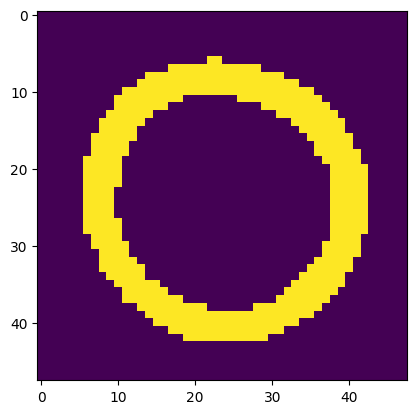

In [ ]:
plt.imshow(inference_mask)

In [ ]:
plt.imshow(DENSE_strain_mask)

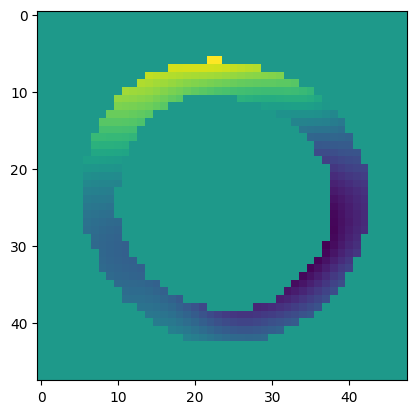

In [ ]:
plt.imshow(check_datum['DENSE_Lag_displacement_field_X'][None][0,...,30])

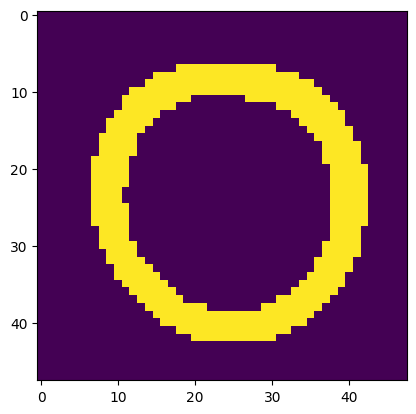

In [ ]:
plt.imshow(check_datum['DENSE_myo_masks'][...,0])

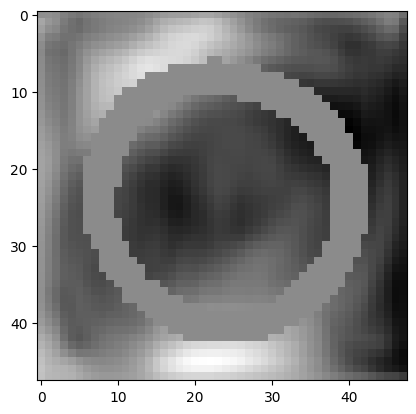

In [ ]:
plt.imshow(inference_disp[0,0,10] - inference_disp_masked[0,0,10], cmap='gray')

In [ ]:
print(DENSE_origin)
print(DENSE_insertion)

[25.31962217 25.24238535]
[14.3796845   9.85869309]


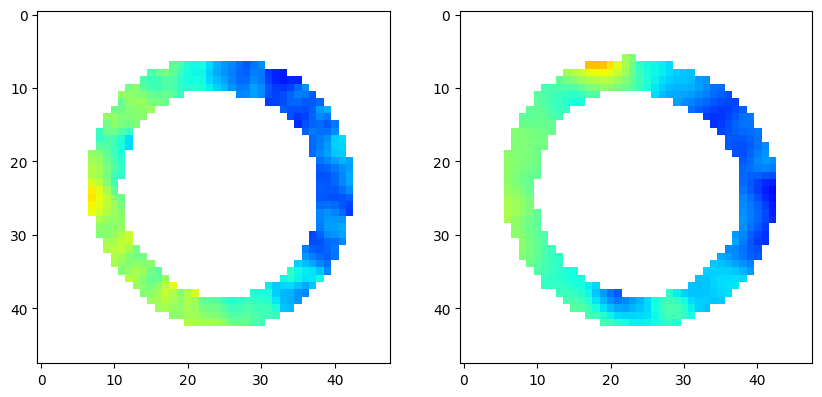

In [ ]:
check_frame_idx = 30
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(strain['CC'][...,check_frame_idx], cmap='jet', vmin=-0.2, vmax=0.2)
axs[1].imshow(strain_GT['CC'][...,check_frame_idx], cmap='jet', vmin=-0.2, vmax=0.2)

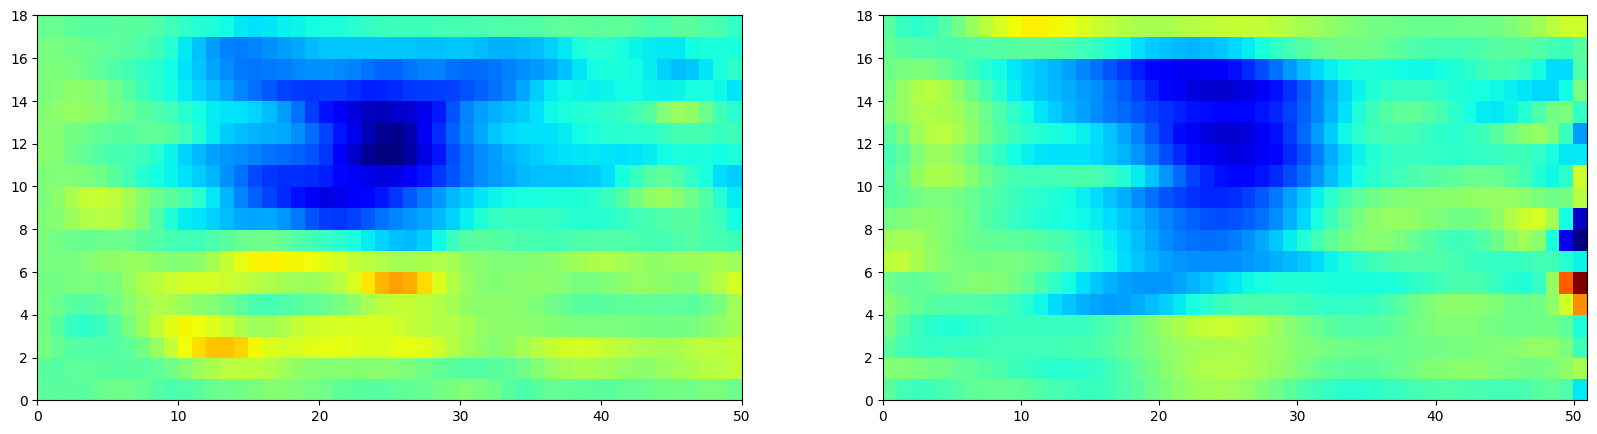

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].pcolor(recompute_strain['CCs18'], cmap='jet', vmin=-0.2, vmax=0.2)
axs[1].pcolor(DENSE_recompute_strain['CCs18'], cmap='jet', vmin=-0.2, vmax=0.2)